In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from helper import plot_anomalies
from Dataset import DatasetLoader
from pyanomaly.stats import MAD, Tukey
from pyanomaly.timeseries import moving_average, moving_average_score, \
                                    twitter, twitter_score

In [2]:
loader = DatasetLoader()
#loader.print_all()

In [3]:
ds_names = loader.get_list('realKnownCause')
ds_names

['ambient_temperature_system_failure.csv',
 'cpu_utilization_asg_misconfiguration.csv',
 'ec2_request_latency_system_failure.csv',
 'machine_temperature_system_failure.csv',
 'nyc_taxi.csv',
 'rogue_agent_key_hold.csv',
 'rogue_agent_key_updown.csv']

## Preprocessamento

In [4]:
df_raw, labels = loader.load('ec2_request_latency_system_failure.csv')
df_raw.head()

,value
timestamp,
2014-03-07 03:41:00,45.868
2014-03-07 03:46:00,47.606
2014-03-07 03:51:00,42.580
2014-03-07 03:56:00,46.030
2014-03-07 04:01:00,44.992


### Valores duplicados e missing data

In [5]:
df_raw.index.duplicated().sum()

11

In [6]:
df_raw[df_raw.index.duplicated()]

,value
timestamp,
2014-03-09 03:00:00,43.578
2014-03-09 03:00:00,47.018
2014-03-09 03:00:00,46.456
2014-03-09 03:00:00,44.368
2014-03-09 03:00:00,43.544
2014-03-09 03:00:00,44.938
2014-03-09 03:00:00,43.834
2014-03-09 03:00:00,47.026
2014-03-09 03:00:00,42.368


In [7]:
df_raw['2014-03-09 02:00:00':'2014-03-09 02:59:00']

,value
timestamp,


In [8]:
df = df_raw.resample('5min').mean()

In [9]:
df.isnull().sum()

value    13
dtype: int64

In [10]:
df.fillna(method='ffill', inplace=True)

In [11]:
df.index.min(), df.index.max(), df.shape

(Timestamp('2014-03-07 03:40:00', freq='5T'),
 Timestamp('2014-03-21 03:40:00', freq='5T'),
 (4033, 1))

In [12]:
pd.date_range(start=df_raw.index.min(), end=df_raw.index.max(), freq='5T')

DatetimeIndex(['2014-03-07 03:41:00', '2014-03-07 03:46:00',
               '2014-03-07 03:51:00', '2014-03-07 03:56:00',
               '2014-03-07 04:01:00', '2014-03-07 04:06:00',
               '2014-03-07 04:11:00', '2014-03-07 04:16:00',
               '2014-03-07 04:21:00', '2014-03-07 04:26:00',
               ...
               '2014-03-21 02:56:00', '2014-03-21 03:01:00',
               '2014-03-21 03:06:00', '2014-03-21 03:11:00',
               '2014-03-21 03:16:00', '2014-03-21 03:21:00',
               '2014-03-21 03:26:00', '2014-03-21 03:31:00',
               '2014-03-21 03:36:00', '2014-03-21 03:41:00'],
              dtype='datetime64[ns]', length=4033, freq='5T')

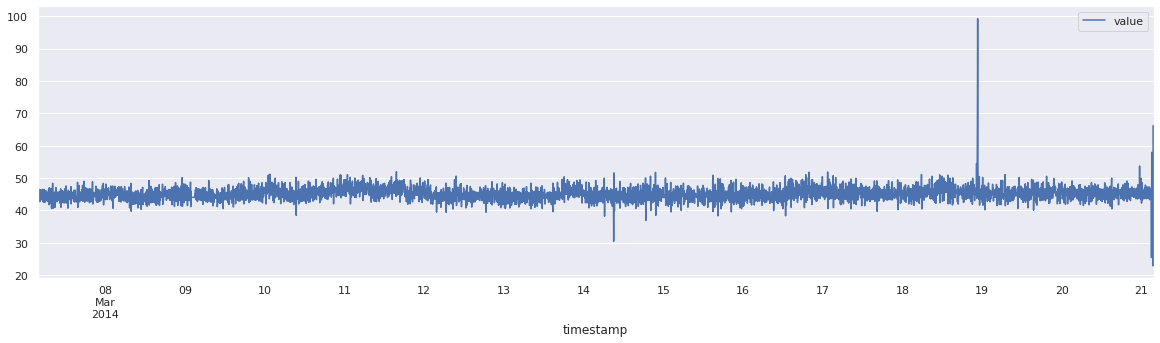

In [13]:
df.plot(figsize=(20, 5))

## Algoritmos

### MAD

In [14]:
mad = MAD()
mad.fit(df['value'])
madscore = mad.decision_function(df['value'])
madpredict = mad.predict(df['value'])
madscore.head()

timestamp
2014-03-07 03:40:00    0.482906
2014-03-07 03:45:00    1.456561
2014-03-07 03:50:00    1.359084
2014-03-07 03:55:00    0.573661
2014-03-07 04:00:00    0.007843
Freq: 5T, Name: value, dtype: float64

Text(0.5, 1.0, 'MAD score - Por ponto')

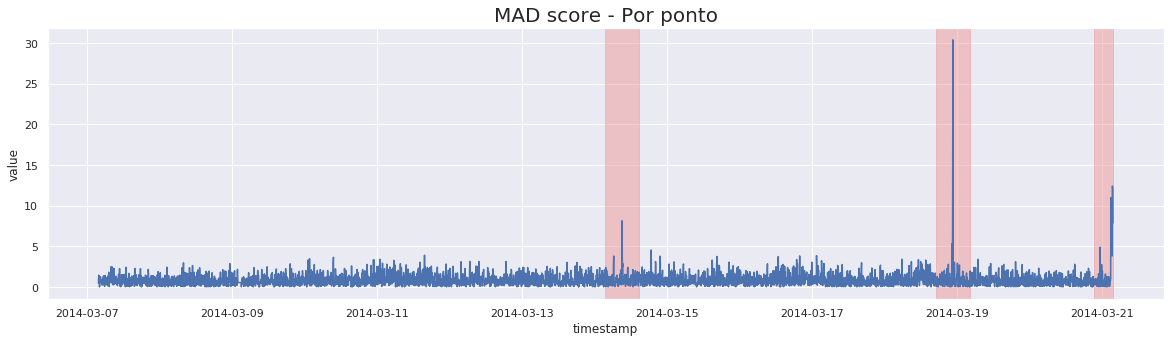

In [15]:
plot_anomalies(madscore, windows=labels)
plt.title("MAD score - Por ponto",fontsize=20)

Text(0.5, 1.0, 'MAD score - Média por Hora')

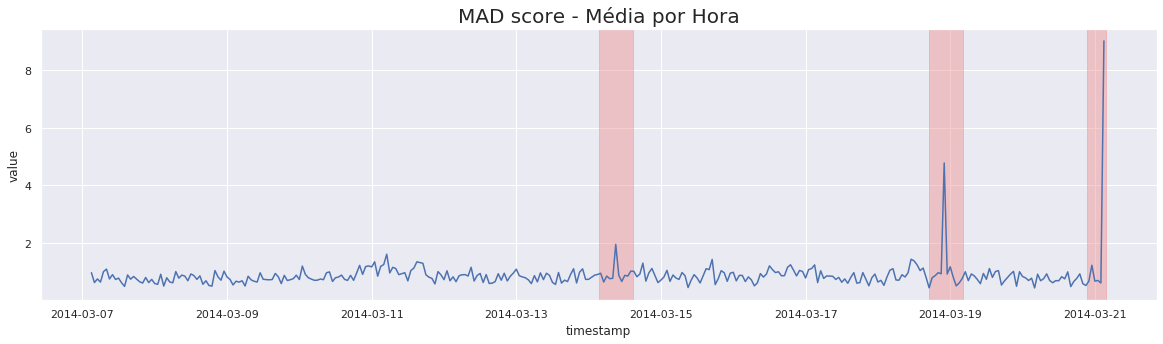

In [16]:
plot_anomalies(madscore.resample('1H').mean(), windows=labels)
plt.title("MAD score - Média por Hora",fontsize=20)

### Tukey

In [17]:
tu = Tukey()
tu.fit(df['value'])
tupredict = tu.predict(df['value'])
tupredict.head()

timestamp
2014-03-08 07:50:00    39.718
2014-03-08 10:50:00    40.306
2014-03-08 23:10:00    50.140
2014-03-09 19:10:00    50.070
2014-03-10 01:05:00    50.906
Name: value, dtype: float64

Text(0.5, 1.0, 'Tukey score - Count do Dia')

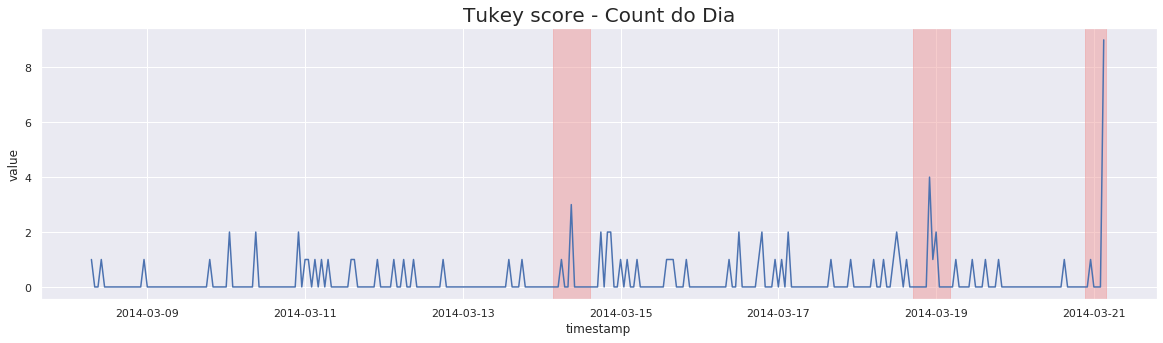

In [18]:
plot_anomalies(tupredict.resample('1H').count().dropna(), windows=labels)
plt.title("Tukey score - Count do Dia",fontsize=20)

### Twitter

In [19]:
twitterscore = twitter_score(df['value'], period=10)
twitterscore

timestamp
2014-03-07 03:40:00     0.563781
2014-03-07 03:45:00     1.224144
2014-03-07 03:50:00     1.026067
2014-03-07 03:55:00     0.266494
2014-03-07 04:00:00     0.130221
                         ...    
2014-03-21 03:20:00     9.801349
2014-03-21 03:25:00     3.919351
2014-03-21 03:30:00    11.495073
2014-03-21 03:35:00     9.716705
2014-03-21 03:40:00     7.439692
Freq: 5T, Length: 4033, dtype: float64

Text(0.5, 1.0, 'Twitter score - Por ponto')

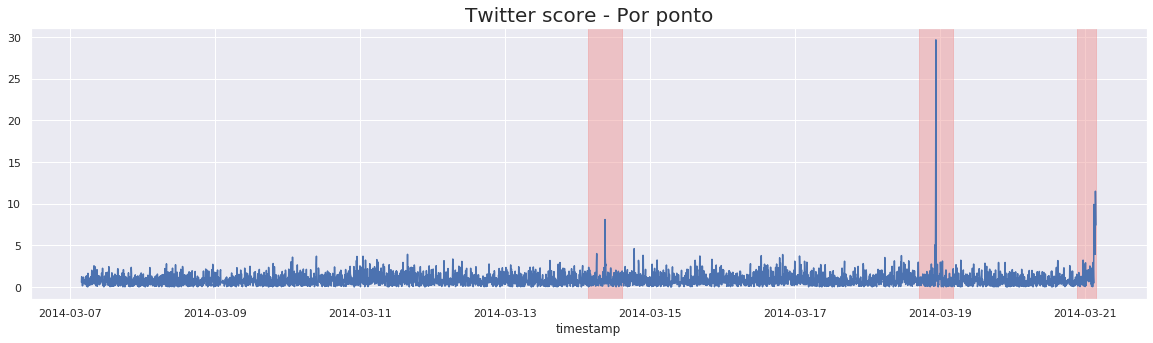

In [20]:
plot_anomalies(twitterscore, windows=labels)
plt.title("Twitter score - Por ponto", fontsize=20)

Text(0.5, 1.0, 'Twitter score - Média do Dia')

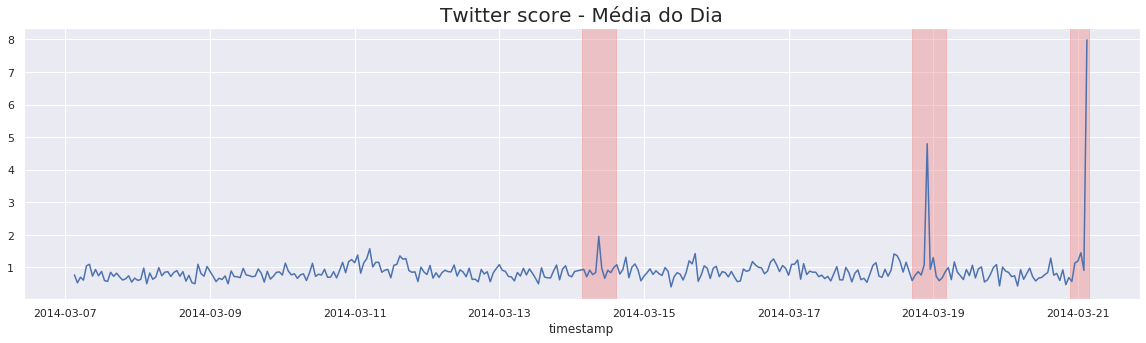

In [21]:
twitterday = twitterscore.resample('1H').mean().dropna()

plot_anomalies(twitterday, windows=labels)
plt.title("Twitter score - Média do Dia",fontsize=20)

### ARIMA/Holt-Winters

In [22]:
#TODO

## Comparação por rank

In [23]:
from helper import top_k_precision, plot_precision_recall_curve

### Resample

In [24]:
# Resample os dados para cada Hora
madscore_day = madscore.resample('1H').mean().dropna()
tuscore_day = tupredict.resample('1H').count().dropna()
twitterscore_day = twitterscore.resample('1H').mean().dropna()

In [25]:
# Calculando top k precision para cada tecnica
mad_topk = top_k_precision(madscore_day, labels, k=5)
tu_topk = top_k_precision(tuscore_day, labels, k=5)
twitter_topk = top_k_precision(twitterscore_day, labels, k=5)

df_topk = pd.DataFrame({'mad': mad_topk,
                        'tukey': tu_topk,
                        'twitter': twitter_topk},
                        index=np.arange(1, 6))
df_topk

,mad,tukey,twitter
1,1.00,1.00,1.00
2,1.00,1.00,1.00
3,1.00,1.00,1.00
4,0.75,0.75,0.75
5,0.60,0.60,0.60


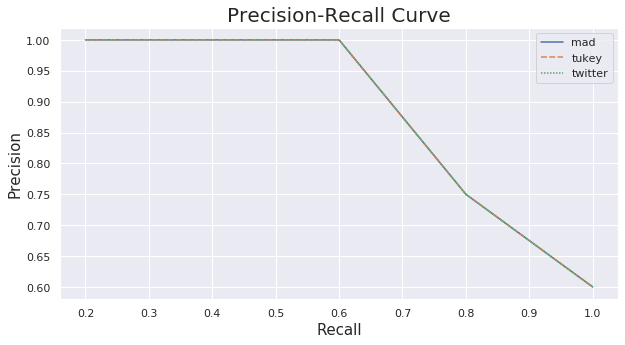

In [26]:
fig, ax = plot_precision_recall_curve(df_topk)

### Save

In [27]:
df_topk.index.names = ['rank']
df_topk.to_csv('./results/' + 'topk_score_' + ds_names[0])

In [28]:
fig.savefig('./results/' + 'topk_score_' + ds_names[0].split('.')[0] + '.jpg')